# Загрузка Pandas и очистка данных

In [45]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import missingno as msno

In [36]:
data = pd.read_csv('main_task_new.csv')

In [37]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

DEBUG = False
''' Вывод табицы с отбором по колонке и ее пустым значениям'''
def show_nan_value(column, df_work):    
    display(df_work[students[column].isnull().values][:])

''' Статистика колонки: квартили, границы выбросов'''    
def stat_column(column, df_work):
    perc25 = df_work[column].quantile(0.25)
    perc75 = df_work[column].quantile(0.75)
    IQR = perc75 - perc25
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    df_work[column].loc[df_work[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 10), label = 'IQR')
    
''' Анализ колонки '''
def analis_column(column, df_work):
    df_work[column] = df_work[column].apply(lambda x: None if x == 'nan'  else x)
    if DEBUG:
        #students.drop(students[(students.score == 0) | (students['score'].isnull())].index, inplace=True)        
        display(df_work[column].value_counts())
        
    # замена на медиану пустых значений
    is_null = df_work[column].isnull().sum()
    if is_null>0:
        print(f'Пустых значений в {column}: {is_null}, Требуется замена')        
        #: {students[column].median()}'
        #students.score.hist()
    display(df_work[column].unique())    
    display(df_work.loc[:, [column]].info())
    display(df_work[column].describe())
    df_work[column].hist()

'''Заполнение пустых значении равномерным распределением'''
def division_column(column, df_work):

    df = df_work[column].value_counts().to_frame()
    # шаг для заполнения  равен пустые значения/количество значений в колонке
    is_null = df_work[column].isnull().sum()    
    step = round(is_null/len(df),0)
    if DEBUG: print(f'нулевых:{is_null} шаг:{step}')
    last_idx = None
    for idx, str_df in df.iterrows():
        counter = 0
        for index, str_stud in df_work[df_work[column].isnull()].iterrows():
            if counter < step:
                counter += 1
                df_work.loc[index, column] = idx            
                last_idx = idx
            else: break
    
    is_null = df_work[column].isnull().sum()
    if is_null > 0:
        for index, str_stud in df_work[df_work[column].isnull()].iterrows():
            df_work.loc[index, column] = last_idx            
    
    if DEBUG: print(f'нулевых:{is_null}')


Пустых значений в Number of Reviews: 2543, Требуется замена


array([ 194.,   10.,  688., ..., 2297.,  989., 1162.])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Number of Reviews  37457 non-null  float64
dtypes: float64(1)
memory usage: 312.6 KB


None

count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

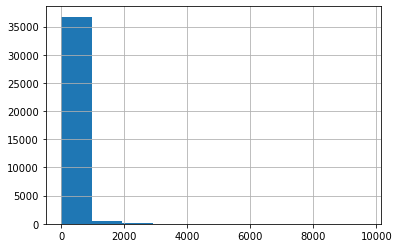

In [38]:
analis_column('Number of Reviews', data)

<AxesSubplot:xlabel='City'>

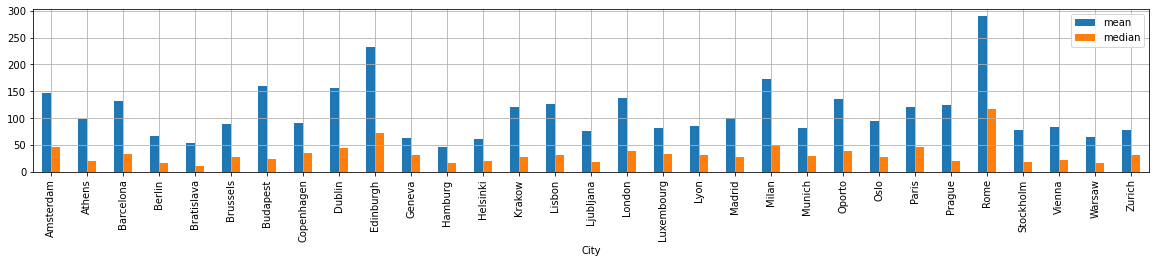

In [39]:
data.groupby(['City'])['Number of Reviews'].agg(['mean','median']).plot(kind='bar',figsize=[20,3],grid=True)

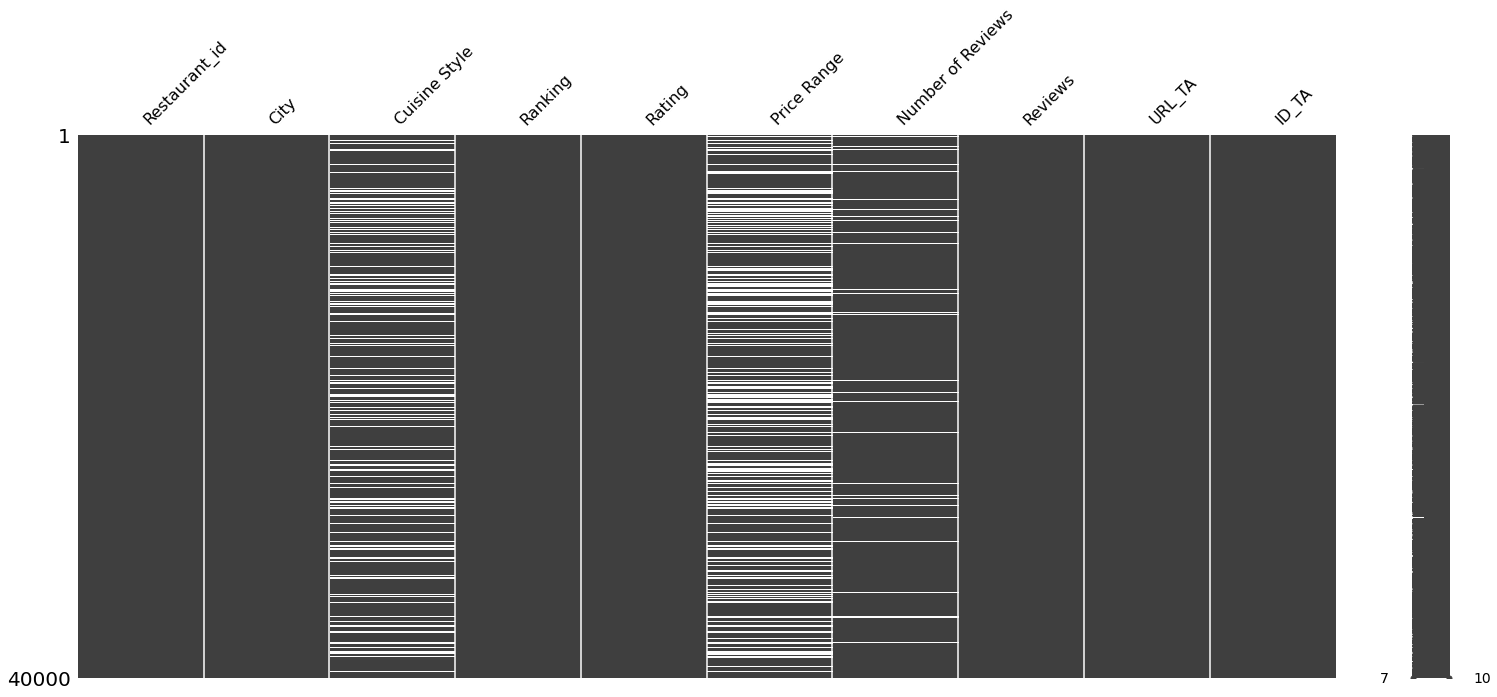

In [46]:
#анализ пустых значений
msno.matrix(data)
plt.show()

In [22]:
# Заполнение пропусков средними значениями
#data['Number of Reviews'].fillna(data['Number of Reviews'].mean(), inplace =True)
gb_city = round(data.groupby(['City'])['Number of Reviews'].median()).to_dict() # создаем словарь
data['Number of Reviews'].fillna(data['City'].map(gb_city),inplace=True) # заменяем пропуски, применяя словарь

data['Ranking'].fillna(data['Ranking'].mean(), inplace =True)
data['Rating'].fillna(data['Rating'].mean(), inplace =True)
data['Cuisine Style'].fillna("International", inplace=True)

'''# Заполнение пропусков равномерным распределением
division_column('Number of Reviews', data)
division_column('Ranking', data)
division_column('Rating', data)'''
# медиан дали худший результат

# подготовка колонки к обработке
def len_cuisine(style1):
    style = str(style1)
    style = style.replace("[",'').replace("]",'').replace("'","").replace(", ",",")
    return style.split(',')


data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x:len_cuisine(x))

# подсчет количества свойств строки
def len_cuisine1(style):

    if style == None:
        return 1
    else: 
        l_style = style.split(', ')
        return len(l_style)

data['len Cuisine Style'] = data['Cuisine Style'].apply(lambda x:len(x))

# расчет разности отзывов в днях
def review_to_variance(review):
    pattern = re.compile('\'\d+\/\d+\/\d+\'?')
    dat = pattern.findall(review)
    if len(dat) >= 2:
        datetime_list = []
        for date in dat:
            date = date[1:-1]
            dt = pd.to_datetime(date)#datetime.datetime.strptime(date, '%m/%d/%Y')
            datetime_list.append(dt)
        if datetime_list[0] > datetime_list[1]:
            variance = (datetime_list[0] - datetime_list[1]).days
        else:
            variance = (datetime_list[1] - datetime_list[0]).days
            
        #проверка на ошибки в отзывах, больше года ошибка    
        if variance > 365:
            return 365
        else:
            return variance
        
    else:
        return 0
    
data['review_variance'] = data['Reviews'].apply(lambda x: review_to_variance(x))

# выделение последнего отзыва
def review_to_date(review):
    pattern = re.compile('\'\d+\/\d+\/\d+\'?')
    dat = pattern.findall(review)
    if len(dat) == 0:
        return pd.to_datetime(np.nan)  
    else:
        datetime_list = []
        for date in dat:
            dt = pd.to_datetime(date)#datetime.datetime.strptime(date, '%m/%d/%Y')
            datetime_list.append(dt)
        if len(datetime_list)>1:
            if datetime_list[0] > datetime_list[1]:
                return datetime_list[0]
            else:
                return datetime_list[1]
        else: return datetime_list[0]
                
    
data['review_last'] = data['Reviews'].apply(lambda x: review_to_date(x))

# проверка nan даты последнего отзыва
data['review_last'].isna().sum()


6471

In [23]:
# заполнение nan даты последнего отзыва ближайшей датой
max_data = data['review_last'].max()
data['review_last'].fillna(max_data, inplace=True)

# новая колонка день последнего отзыва
data['review_day'] = data['review_last'].dt.weekday
data['review_month'] = data['review_last'].dt.month
data['review_year'] = data['review_last'].dt.year
#data['review_day'].fillna(data['review_day'].mean(), inplace =True)

# новая колонка объединенный рэйтинг
data['Rating_union'] =data['Ranking']**0.5

def count_range1(colum):
    colum = str(colum)
    if (np.nan == colum)or('nan'==colum):
        return 0
    elif '$$$$' in colum:   #colum.isnan():
        return 3
    elif '$$ - $$$' in colum:   #colum.isnan():
        return 2
    else:
        return 1

# новая колока классификация цены    
data['Price Range count'] = data['Price Range'].apply(lambda x: count_range1(x))


In [24]:
# добавление dummy variables plus_world и mins_world соответственно комплимент и ругательства
#вражения из словаря в интернете
plus_world = "good,better,yummy,mouth-watering,scrumptious,very rich,decadent,amazing,fresh,delicious,sweet"
plus_world = plus_world.split(',')

minus_world = "bad,worst,don't, not "
minus_world = minus_world.split(',')

def count_plus_word(colum):
    colum= str(colum).lower()
    sum = 0
    for word in plus_world:
        if word in colum:
            sum += 1
    return sum

data['plus_word'] = data['Reviews'].apply(lambda x: count_plus_word(x))

def count_minus_word(colum):
    colum= str(colum).lower()
    sum = 0
    for word in minus_world:
        if word in colum:
            sum += 1
    return sum    
    
data['minus_world'] = data['Reviews'].apply(lambda x: count_minus_word(x))

In [25]:
data.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,len Cuisine Style,review_variance,review_last,review_day,review_month,review_year,Rating_union,Price Range count,plus_word,minus_world
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,41,2017-12-31,6,12,2017,74.632433,2,1,0


In [26]:
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

# Добавляем также dummies признак для типов кухни
df1 = data[['Cuisine Style']].copy()
df1 = pd.get_dummies(df1['Cuisine Style'].explode(), prefix = 'cuis').sum(level=0)
data = pd.concat([data,df1],axis=1)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [27]:
df = data.drop(['Restaurant_id','review_last',], axis = 1)
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)

# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
#X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']
#df.info()
#object_columns
#df.columns

In [28]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [29]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [30]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [31]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [32]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21584699999999998


MAE: 0.21665749999999998